## IMPORTS

In [141]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import nltk
from nltk.tokenize import ToktokTokenizer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.naive_bayes import MultinomialNB

## FUNCTIONS

In [142]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    """
    Generate distribution graphs (histogram/bar graph) for each column in the DataFrame.

    Args:
    - df (DataFrame): The input DataFrame containing the data.
    - nGraphShown (int): The maximum number of graphs to be shown.
    - nGraphPerRow (int): The number of graphs to be displayed per row.

    Returns:
    - None: The function displays the graphs but does not return any value.
    """
    nunique = df.nunique()
    # For displaying purposes, pick columns that have between 1 and 50 unique values
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] 
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation=90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

In [143]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    """
    Generate a correlation matrix plot for the DataFrame.

    Args:
    - df (DataFrame): The input DataFrame containing the data.
    - graphWidth (int): The width of the correlation matrix plot.

    Returns:
    - None: The function displays the correlation matrix plot but does not return any value.
    """
    filename = df.dataframeName
    df = df.dropna()  # Drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]]  # Keep columns where there are more than 1 unique values
    df = df.select_dtypes(include=['int', 'float'])
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [144]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    """
    Generate scatter and density plots for numerical columns in the DataFrame.

    Args:
    - df (DataFrame): The input DataFrame containing the data.
    - plotSize (int): The size of the scatter matrix plot.
    - textSize (int): The size of the text annotations.

    Returns:
    - None: The function displays the scatter and density plots but does not return any value.
    """
    df = df.select_dtypes(include=[np.number])  # Keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]]  # Keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10:  # Reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=(plotSize, plotSize), diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k=1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


In [145]:
def strip_html(text):
    """
    Remove HTML tags from the input text.

    Args:
    - text (str): The input text containing HTML tags.

    Returns:
    - str: The text with HTML tags removed.
    """
    if isinstance(text, str):  # Check if the text is a string
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()
    else:
        return text


In [146]:
def remove_between_square_brackets(text):
    """
    Remove text between square brackets (including the brackets) from the input text.

    Args:
    - text (str): The input text.

    Returns:
    - str: The text with content between square brackets removed.
    """
    if isinstance(text, str):  # Check if the text is a string
        return re.sub(r'\[[^]]*\]', '', text)
    else:
        return text


In [147]:
# Define the complete text cleaning function
def denoise_text(text):
    """
    Perform text denoising by removing HTML tags and text between square brackets.

    Args:
    - text (str): The input text.

    Returns:
    - str: The denoised text without HTML tags and content between square brackets.
    """
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text


In [148]:
def remove_special_characters(text, remove_digits=True):
    """
    Remove special characters from the input text.

    Args:
    - text (str): The input text.
    - remove_digits (bool): Whether to remove digits or not. Default is True.

    Returns:
    - str: The text with special characters removed.
    """
    if isinstance(text, str):
        pattern = r'[^a-zA-z0-9\s]'
        text = re.sub(pattern, '', text)
        if remove_digits:
            text = re.sub(r'\d+', '', text)  # Remove digits if specified
        return text
    else:
        return text


In [149]:
def simple_stemmer(text):
    """
    Perform simple stemming on the input text using the NLTK Porter Stemmer.

    Args:
    - text (str): The input text.

    Returns:
    - str: The text with words stemmed using the Porter Stemmer.
    """
    if isinstance(text, str):
        ps = nltk.porter.PorterStemmer()
        text = ' '.join([ps.stem(word) for word in text.split()])
        return text
    else:
        return text

In [150]:
def remove_stopwords(text, is_lower_case=False):
    """
    Remove stopwords from the input text.

    Args:
    - text (str): The input text.
    - is_lower_case (bool): Whether the text is lowercased or not. Default is False.

    Returns:
    - str: The text with stopwords removed.
    """
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text


In [151]:
def plot_confusion_matrix(cm, labels):
    """
    Plot the confusion matrix.

    Args:
    - cm (array): The confusion matrix.
    - labels (list): The list of class labels.

    Returns:
    - None: The function displays the confusion matrix plot but does not return any value.
    """
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font size

    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

## EXPLORATORY DATA ANALYSIS

In [152]:
nRowsRead = None # specify 'None' if want to read whole file
df1 = pd.read_csv('Womens_Clothing_E-Commerce_Reviews.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'Womens Clothing E-Commerce Reviews.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 23486 rows and 11 columns


In [153]:
df1.head(10)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
7,7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits
8,8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses


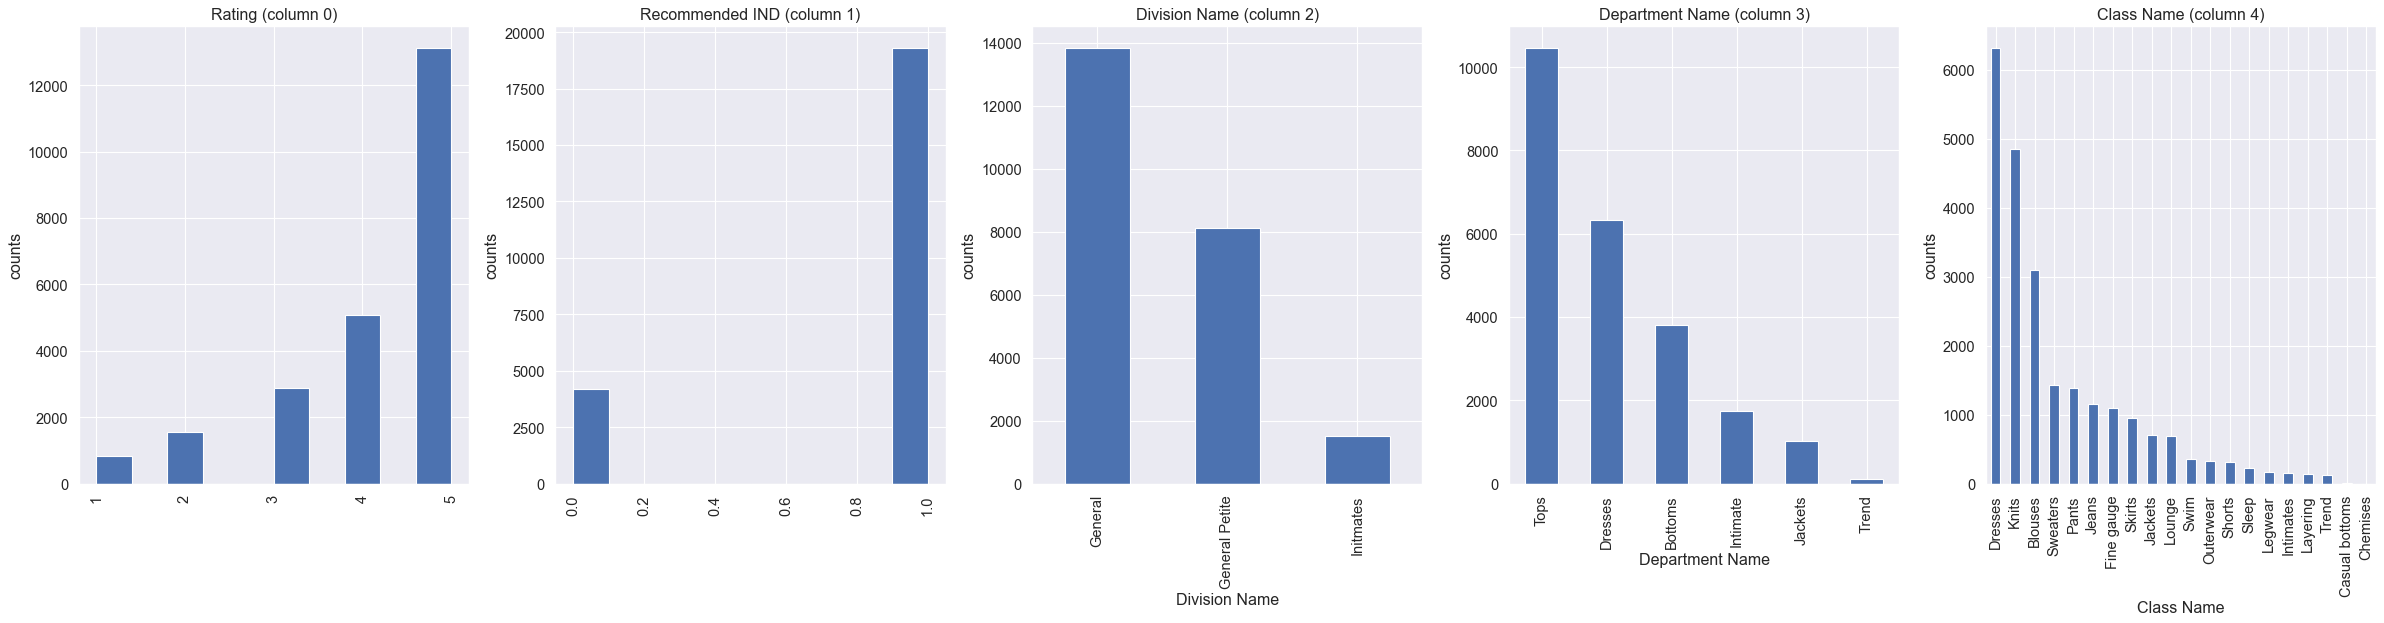

In [154]:
plotPerColumnDistribution(df1, 10, 5)

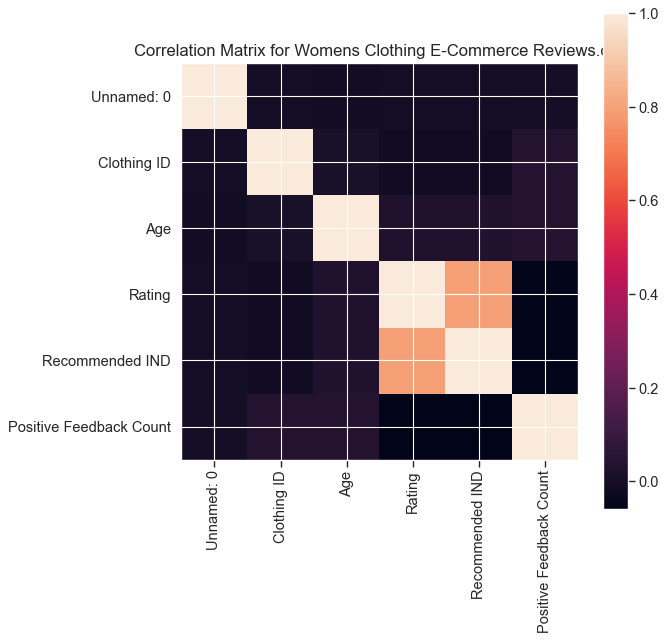

In [155]:
plotCorrelationMatrix(df1, 8)

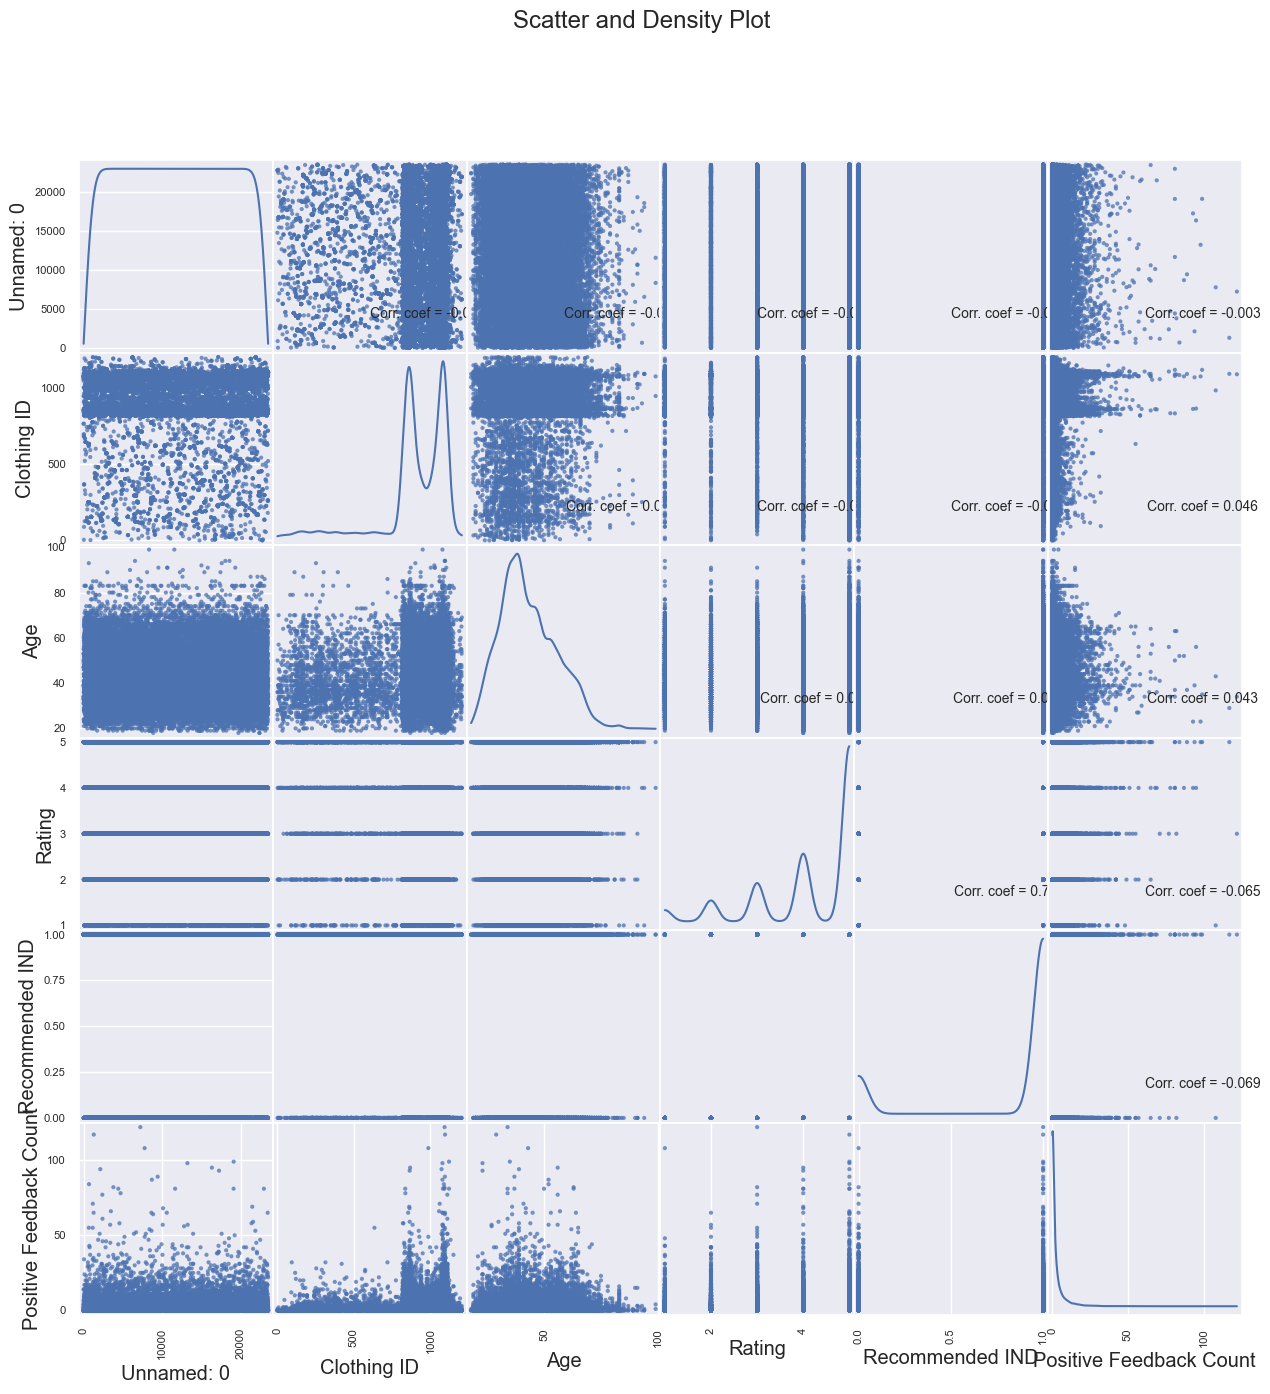

In [156]:
plotScatterMatrix(df1, 15, 10)

## DATA PREPROCESSING

In [157]:
df1['Rating'].value_counts()

Rating
5    13131
4     5077
3     2871
2     1565
1      842
Name: count, dtype: int64

In [158]:
df1['Recommended IND'].value_counts()

Recommended IND
1    19314
0     4172
Name: count, dtype: int64

In [159]:
df1 = df1[['Review Text' , 'Recommended IND']]

In [160]:
df1['Recommended IND'].astype('object')

0        1
1        1
2        0
3        1
4        1
        ..
23481    1
23482    1
23483    0
23484    1
23485    1
Name: Recommended IND, Length: 23486, dtype: object

In [161]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review Text      22641 non-null  object
 1   Recommended IND  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 367.1+ KB


In [162]:
balanced_df = pd.concat([df1[df1['Recommended IND'] == 0], df1[df1['Recommended IND'] == 1].sample(n=4200)], axis=0)

In [163]:
balanced_df = balanced_df.sample(len(balanced_df))

In [164]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8372 entries, 6909 to 16357
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review Text      8140 non-null   object
 1   Recommended IND  8372 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 196.2+ KB


<Axes: xlabel='count', ylabel='Recommended IND'>

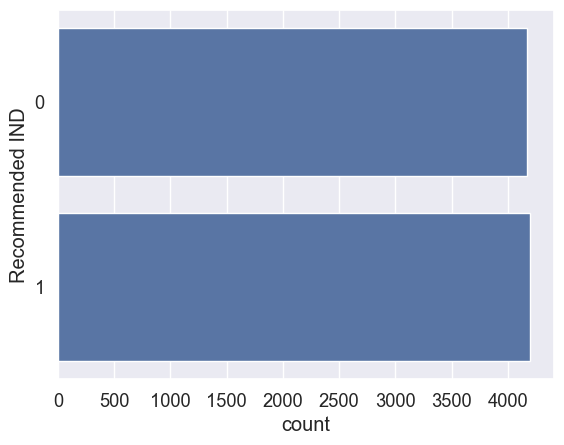

In [165]:
sns.countplot(y = balanced_df['Recommended IND'])

In [166]:
balanced_df['Recommended IND'] = balanced_df['Recommended IND'].astype('category')

In [167]:
balanced_df.describe()

,Review Text,Recommended IND
count,8140,8372
unique,8138,2
top,I purchased this and another eva franco dress ...,1
freq,2,4200


In [168]:
balanced_df['Recommended IND'].value_counts()

Recommended IND
1    4200
0    4172
Name: count, dtype: int64

In [169]:
balanced_df.rename(columns={'Recommended IND': 'Recommended_Category'}, inplace=True)
balanced_df.rename(columns={'Review Text': 'Review'}, inplace=True)

In [170]:
#split the dataset
#train dataset
num = int(len(balanced_df)*0.8)
train_reviews=balanced_df.Review[:num]
train_sentiments=balanced_df.Recommended_Category[:num]
#test dataset
test_reviews=balanced_df.Review[num:]
test_sentiments=balanced_df.Recommended_Category[num:]
print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(6697,) (6697,)
(1675,) (1675,)


In [171]:
nltk.download('stopwords')
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jorge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [172]:
# Aplicar la función de limpieza al dataframe
balanced_df['Review'] = balanced_df['Review'].apply(denoise_text)

C:\Users\jorge\AppData\Local\Temp\ipykernel_12784\826804364.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [173]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8372 entries, 6909 to 16357
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Review                8140 non-null   object  
 1   Recommended_Category  8372 non-null   category
dtypes: category(1), object(1)
memory usage: 139.1+ KB


In [174]:
#Aply function for removing special characters
balanced_df['Review'] = balanced_df['Review'].apply(remove_special_characters)

In [175]:
#Apply function for Stemming the text
balanced_df['Review'] = balanced_df['Review'].apply(simple_stemmer)

In [176]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#Apply function for removing the stopwords
balanced_df['Review'] = balanced_df['Review'].apply(remove_stopwords)

{'yourselves', "she's", "didn't", "mightn't", 'am', 'hadn', 'but', 'only', 'or', 'a', 'those', 'again', 'no', 't', 'doesn', 'about', 'be', "weren't", 'we', 'couldn', 'above', 'has', "isn't", 'myself', 'did', 'there', 'nor', 're', "aren't", 'themselves', "hadn't", 'they', 'these', 'haven', 'do', 'when', "you're", 'it', 'between', 'whom', "shan't", 'too', 'where', 'at', 'for', 'by', 'ma', 'all', 'him', "it's", 've', 'ain', 'had', 'shouldn', 'this', 'needn', 'my', 'until', 'yourself', 'does', 'then', 'weren', 'were', 'an', 'yours', 'his', 'that', 'each', 'shan', 'them', 'himself', 'further', 'the', "mustn't", 'of', 'hers', 'theirs', 'because', 'which', 'so', 'than', "hasn't", 'our', 'me', 'most', "won't", 'being', 'while', 'on', 'from', 'once', "should've", 'mustn', 'same', "couldn't", 'have', 'was', 'its', 'few', 'y', 'should', 'after', "wouldn't", 'ours', 'through', 'wasn', 'with', 'hasn', 'why', 'isn', 'mightn', 'don', 'into', 'm', 'out', 'll', 'as', 'before', 'is', 'in', 'their', 'o',

In [177]:
norm_train_reviews=balanced_df.Review[:num]
norm_test_reviews=balanced_df.Review[num:]

In [178]:
len(norm_train_reviews)

6697

In [179]:
len(norm_test_reviews)

1675

## MODELING

In [180]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0.0,max_df=1.0,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)
#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names

BOW_cv_train: (6697, 272753)
BOW_cv_test: (1675, 272753)


In [181]:
#Tfidf vectorizer
tv=TfidfVectorizer(min_df=0.0,max_df=1.0,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (6697, 272753)
Tfidf_test: (1675, 272753)


In [182]:
#labeling the sentient data
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data=lb.fit_transform(balanced_df['Recommended_Category'])
print(sentiment_data.shape)

(8372, 1)


In [183]:
train_sentiments=sentiment_data[:num]
test_sentiments=sentiment_data[num:]
print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [0]]
[[1]
 [0]
 [1]
 ...
 [1]
 [1]
 [1]]


In [184]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

C:\Users\jorge\Documents\MasterBD\Datos_no_estructurados\PracticasAna\.venv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


C:\Users\jorge\Documents\MasterBD\Datos_no_estructurados\PracticasAna\.venv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, max_iter=500, random_state=42)


In [185]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 0 1 ... 1 1 0]
[1 0 1 ... 1 1 0]


In [186]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.8191044776119403
lr_tfidf_score : 0.8382089552238806


In [187]:
#Classification report for bag of words
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['1','0'])
print(lr_bow_report)

#Classification report for tfidf features
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['1','0'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

           1       0.80      0.85      0.83       839
           0       0.84      0.79      0.81       836

    accuracy                           0.82      1675
   macro avg       0.82      0.82      0.82      1675
weighted avg       0.82      0.82      0.82      1675

              precision    recall  f1-score   support

           1       0.83      0.85      0.84       839
           0       0.85      0.83      0.84       836

    accuracy                           0.84      1675
   macro avg       0.84      0.84      0.84      1675
weighted avg       0.84      0.84      0.84      1675


Confusion Matrix for Bag of Words:
[[657 179]
 [124 715]]


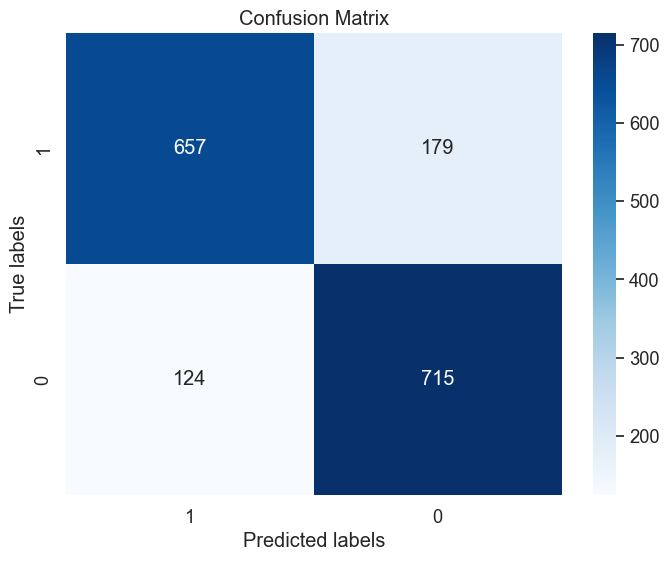

Confusion Matrix for TF-IDF:
[[690 146]
 [125 714]]


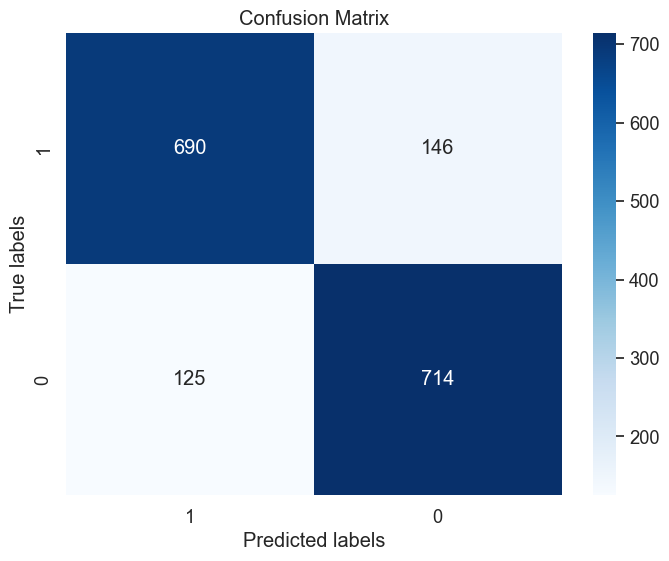

In [188]:
# Matriz de confusión para Bag of Words
cm_bow = confusion_matrix(test_sentiments, lr_bow_predict, labels=[1, 0])
print("Confusion Matrix for Bag of Words:")
print(cm_bow)
plot_confusion_matrix(cm_bow, labels=['1', '0'])

# Matriz de confusión para TF-IDF
cm_tfidf = confusion_matrix(test_sentiments, lr_tfidf_predict, labels=[1, 0])
print("Confusion Matrix for TF-IDF:")
print(cm_tfidf)
plot_confusion_matrix(cm_tfidf, labels=['1', '0'])

In [189]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


C:\Users\jorge\Documents\MasterBD\Datos_no_estructurados\PracticasAna\.venv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jorge\Documents\MasterBD\Datos_no_estructurados\PracticasAna\.venv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [190]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[1 0 1 ... 1 1 0]
[1 0 1 ... 1 1 0]


In [191]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.8483582089552238
mnb_tfidf_score : 0.8531343283582089


In [192]:
#Classification report for bag of words
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['1','0'])
print(mnb_bow_report)
#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['1','0'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

           1       0.82      0.90      0.86       839
           0       0.89      0.80      0.84       836

    accuracy                           0.85      1675
   macro avg       0.85      0.85      0.85      1675
weighted avg       0.85      0.85      0.85      1675

              precision    recall  f1-score   support

           1       0.83      0.90      0.86       839
           0       0.89      0.81      0.85       836

    accuracy                           0.85      1675
   macro avg       0.86      0.85      0.85      1675
weighted avg       0.86      0.85      0.85      1675


Confusion Matrix for Bag of Words (Multinomial Naive Bayes):
[[665 171]
 [ 83 756]]


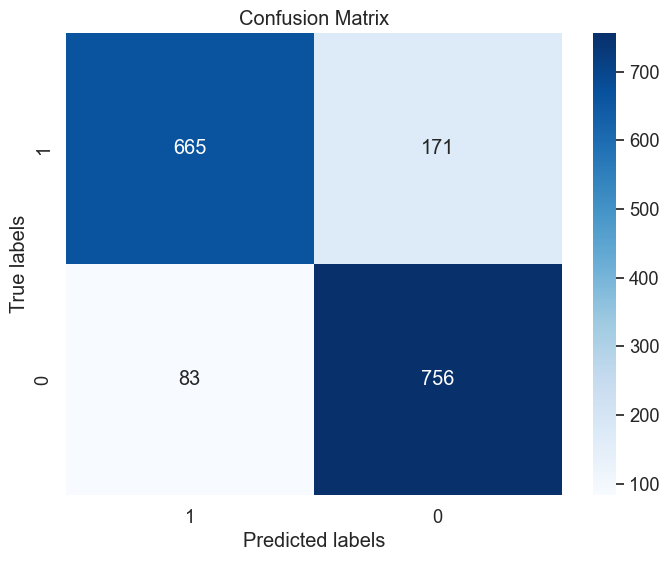

Confusion Matrix for TF-IDF (Multinomial Naive Bayes):
[[678 158]
 [ 88 751]]


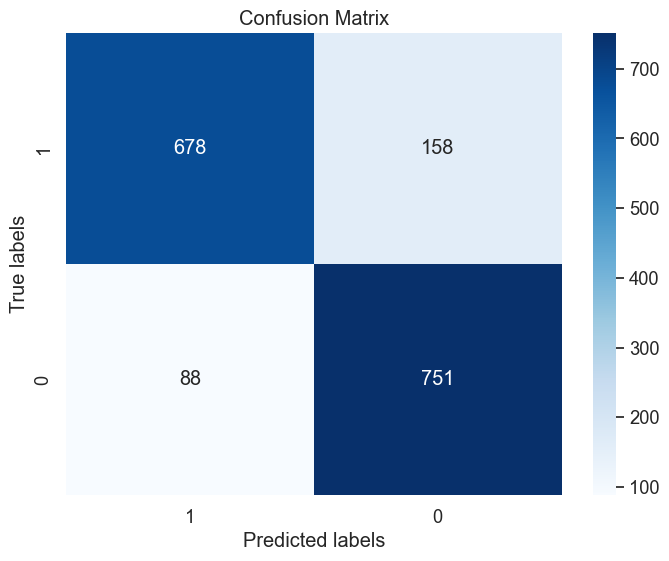

In [193]:
# Matriz de confusión para Bag of Words con Naive Bayes Multinomial
cm_bow_mnb = confusion_matrix(test_sentiments, mnb_bow_predict, labels=[1, 0])
print("Confusion Matrix for Bag of Words (Multinomial Naive Bayes):")
print(cm_bow_mnb)
plot_confusion_matrix(cm_bow_mnb, labels=['1', '0'])

# Matriz de confusión para TF-IDF con Naive Bayes Multinomial
cm_tfidf_mnb = confusion_matrix(test_sentiments, mnb_tfidf_predict, labels=[1, 0])
print("Confusion Matrix for TF-IDF (Multinomial Naive Bayes):")
print(cm_tfidf_mnb)
plot_confusion_matrix(cm_tfidf_mnb, labels=['1', '0'])